<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SHAP

Installation

In [1]:
!pip install -q interpret shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00


Download the dataset

In [2]:
!git clone https://github.com/mobarakol/AI_Medical_Imaging.git
%cd AI_Medical_Imaging

Cloning into 'AI_Medical_Imaging'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 4), reused 9 (delta 0), pack-reused 0
Receiving objects: 100% (21/21), 140.27 KiB | 1.45 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/AI_Medical_Imaging


#Stroke Prediction Dataset
Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset<br>

Attribute Information<br>
1) id: unique identifier<br>
2) gender: "Male", "Female" or "Other"<br>
3) age: age of the patient<br>
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension<br>
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease<br>
6) ever_married: "No" or "Yes"<br>
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"<br>
8) Residence_type: "Rural" or "Urban"<br>
9) avg_glucose_level: average glucose level in blood<br>
10) bmi: body mass index<br>
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*<br>
12) stroke: 1 if the patient had a stroke or 0 if not

In [3]:
%cd /content/AI_Medical_Imaging
import pandas as pd
path = '/content/AI_Medical_Imaging/data/healthcare-dataset-stroke-data.csv'
data = pd.read_csv(path)
print('Sample Size:', len(data))
data.head(5)

/content/AI_Medical_Imaging
Sample Size: 5110


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#Dataloader

In [4]:
%cd /content/AI_Medical_Imaging
import pandas as pd
# Makes sure we see all columns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

class DataLoader():
    def __init__(self):
        self.data = None

    def load_dataset(self, path="data/healthcare-dataset-stroke-data.csv"):
        self.data = pd.read_csv(path)

    def preprocess_data(self):
        # One-hot encode all categorical columns
        categorical_cols = ["gender",
                            "ever_married",
                            "work_type",
                            "Residence_type",
                            "smoking_status"]
        encoded = pd.get_dummies(self.data[categorical_cols],
                                prefix=categorical_cols)

        # Update data with new columns
        self.data = pd.concat([encoded, self.data], axis=1)
        self.data.drop(categorical_cols, axis=1, inplace=True)

        # Impute missing values of BMI
        self.data.bmi = self.data.bmi.fillna(0)

        # Drop id as it is not relevant
        self.data.drop(["id"], axis=1, inplace=True)

        # Standardization
        # Usually we would standardize here and convert it back later
        # But for simplification we will not standardize / normalize the features

    def get_data_split(self):
        X = self.data.iloc[:,:-1]
        y = self.data.iloc[:,-1]
        return train_test_split(X, y, test_size=0.20, random_state=2021)

    def oversample(self, X_train, y_train):
        oversample = RandomOverSampler(sampling_strategy='minority')
        # Convert to numpy and oversample
        x_np = X_train.to_numpy()
        y_np = y_train.to_numpy()
        x_np, y_np = oversample.fit_resample(x_np, y_np)
        # Convert back to pandas
        x_over = pd.DataFrame(x_np, columns=X_train.columns)
        y_over = pd.Series(y_np, name=y_train.name)
        return x_over, y_over


/content/AI_Medical_Imaging


#SHAP

(7778, 21)
(1022, 21)
F1 Score 0.5342599524755053
Accuracy 0.9452054794520548
(1, 21)


The RF predicted: 0


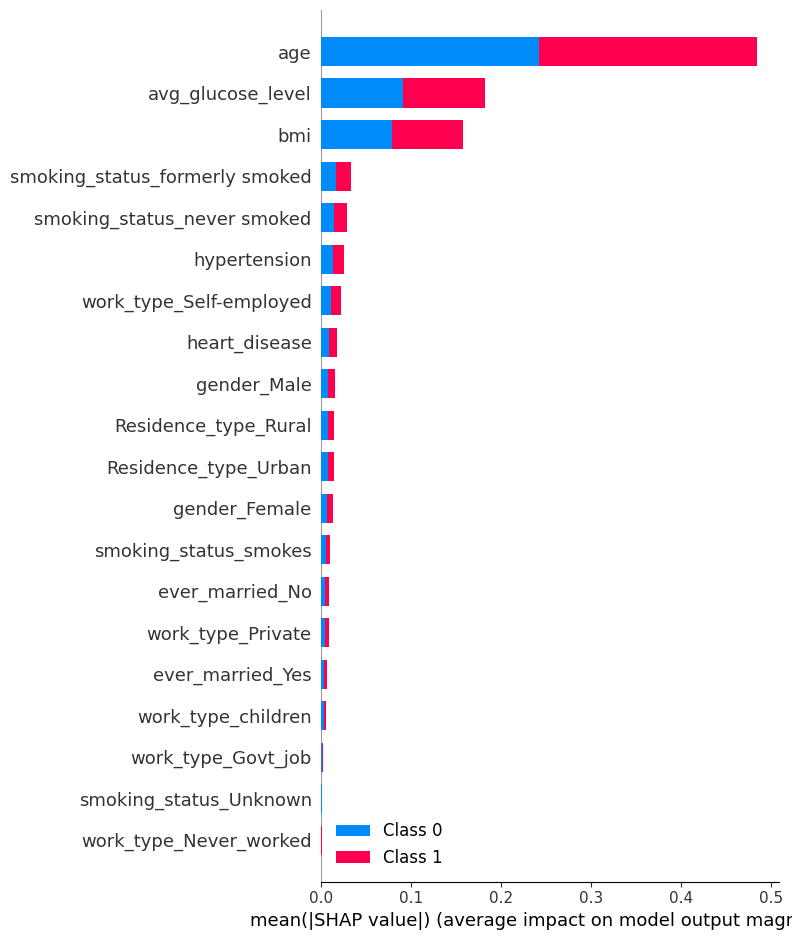

In [6]:
# %% Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import shap

# %% Load and preprocess data
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()
# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print(X_train.shape)
print(X_test.shape)

# %% Fit blackbox model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Create SHAP explainer
explainer = shap.TreeExplainer(rf)
# Calculate shapley values for test data
start_index = 1
end_index = 2
shap_values = explainer.shap_values(X_test[start_index:end_index])
X_test[start_index:end_index]

# %% Investigating the values (classification problem)
# class 0 = contribution to class 1
# class 1 = contribution to class 2
print(shap_values[0].shape)
shap_values

# %% >> Visualize local predictions
shap.initjs()
# Force plot
prediction = rf.predict(X_test[start_index:end_index])[0]
print(f"The RF predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                X_test[start_index:end_index]) # for values

# %% >> Visualize global features
# Feature summary
shap.summary_plot(shap_values, X_test)